<a href="https://colab.research.google.com/github/wander-asb/MRI_CLASSIFICATION/blob/main/MRI_BINARY_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação binária de imagens de ressonâncias magnética em tumores cerebrais

- Bibliografia:
   Link:





## Bibliotecas



In [44]:
#Bibliotecas para modelagem e tratamento de dados
import numpy as np
import pandas as pd
from   google.colab import drive

#Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
from PIL import Image

#Bibliotecas para aprendizado profundo
import torch
from torch import nn, optim
from torchvision import datasets, transforms

print("Versão:",torch.__version__)

Versão: 1.9.0+cu111


## Tratamento de modelagem de dados

In [45]:
#Aplicamos a semente geradora
#torch.manual_seed(123)

In [46]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [47]:
#Cria variáveis responsáveis por receber nosso path de arquivos de dados
path_teste = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/BinaryDatasetBrainTumor/Test'
path_treino = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/BinaryDatasetBrainTumor/Train'

In [48]:
'''
Após recebermos nossos caminhos, transformamos nossos conjuntos de 
dados em tensores, mas fazendo alterações de imagens.
'''
transform_train = transforms.Compose(
    [
        transforms.Resize([128,128]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=45, translate=(0, 0.07), shear=0.2, scale=(1,1.2)),
        transforms.ToTensor()
    ]
)

transform_test = transforms.Compose(
    [
        transforms.Resize([128,128]),
        transforms.ToTensor()
    ]
)

In [49]:
#Aplicamos nossos tensores em tipos de dados dataset
train_dataset = datasets.ImageFolder(path_treino, transform=transform_train)
test_dataset = datasets.ImageFolder(path_teste, transform=transform_test)

In [50]:
print(train_dataset, "\n"*2, test_dataset)

Dataset ImageFolder
    Number of datapoints: 2870
    Root location: /content/gdrive/MyDrive/MRI_TUMOR_CNN/BinaryDatasetBrainTumor/Train
    StandardTransform
Transform: Compose(
               Resize(size=[128, 128], interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-45.0, 45.0], translate=(0, 0.07), scale=(1, 1.2), shear=[-0.2, 0.2])
               ToTensor()
           ) 

 Dataset ImageFolder
    Number of datapoints: 220
    Root location: /content/gdrive/MyDrive/MRI_TUMOR_CNN/BinaryDatasetBrainTumor/Test
    StandardTransform
Transform: Compose(
               Resize(size=[128, 128], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [51]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=True)

## Camadas convolucionais

- convolução1 = (64 - 10 + 1) / 1 = 35x35
- pooling1 = 35/2 = 17x17

-=-=-=-=-=-=-

- convolução2 = (17 - 3 + 1) / 1 = 15x15
- pooling2 = 7x7

-=-=-=-=-=-=-

- convolução3 = (7 - 3 + 1) / 1 = 2x2
- pooling3 = 1x1



In [52]:
'''classificador = nn.Sequential(
    
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10, stride=(1,1)),
    nn.ReflectionPad2d(0),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=64),
    #(128 - 10 + 1)/1 = 119x119
    nn.MaxPool2d(kernel_size=2),
    #119/2 = 58x58

    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=(1,1)),
    nn.ReflectionPad2d(2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    #58/2 = 29x29
    nn.Dropout(p=0.1, inplace=True),

    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=(1,1)),
    nn.ReflectionPad2d(2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    #29/2 = 14x14
    nn.Dropout(p=0.2, inplace=True),
    
    nn.Flatten(),
    nn.Linear(in_features=16384, out_features=128), #in_features = 16384
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)'''

'classificador = nn.Sequential(\n    \n    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10, stride=(1,1)),\n    nn.ReflectionPad2d(0),\n    nn.ReLU(),\n    nn.BatchNorm2d(num_features=64),\n    #(128 - 10 + 1)/1 = 119x119\n    nn.MaxPool2d(kernel_size=2),\n    #119/2 = 58x58\n\n    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=(1,1)),\n    nn.ReflectionPad2d(2),\n    nn.ReLU(),\n    nn.MaxPool2d(kernel_size=2),\n    #58/2 = 29x29\n    nn.Dropout(p=0.1, inplace=True),\n\n    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=(1,1)),\n    nn.ReflectionPad2d(2),\n    nn.ReLU(),\n    nn.MaxPool2d(kernel_size=2),\n    #29/2 = 14x14\n    nn.Dropout(p=0.2, inplace=True),\n    \n    nn.Flatten(),\n    nn.Linear(in_features=16384, out_features=128), #in_features = 16384\n    nn.ReLU(),\n    nn.Linear(128, 128),\n    nn.ReLU(),\n    nn.Linear(128, 1),\n    nn.Sigmoid()\n)'

In [53]:
classificador = nn.Sequential(
    
    nn.Conv2d(in_channels=3, out_channels=128, kernel_size=10, stride=(1,1), padding=(0,0)),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=128),
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=(1,1), padding=(2,2)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.1, inplace=True),

    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=(1,1), padding=(2,2)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.2, inplace=True),


    #conv1 = (128 - 10 + 1) / 1 = 199x119
    #pool = 119 / 2 = 57x57

    #conv2 = (57 - 3 + 1) / 1 = 55x55
    #pool = 55 / 2 = 27

    #conv3 = (27 - 2 + 1) / 1 = 26x26
    #pool3 = 26 / 2 = 13

    #64*13*13
    
    nn.Flatten(),
    nn.Linear(in_features=32768, out_features=256), #in_features = 16384
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

In [54]:
criterion = nn.BCELoss()
optimizer = optim.Adam(classificador.parameters())

## Seta o uso de uma GPU responsável 

In [55]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [56]:
classificador.to(device)

Sequential(
  (0): Conv2d(3, 128, kernel_size=(10, 10), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.1, inplace=True)
  (8): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.2, inplace=True)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=32768, out_features=256, bias=True)
  (14): ReLU()
  (15): Linear(in_features=256, out_features=128, bias=True)
  (16): ReLU()
  (17): Linear(in_features=128, out_features=1, bias=True)
  (18): Sigmoid()
)

## Modelo de treinamendo da Rede Neural 

In [57]:
def training_binary_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = classificador(inputs)
        
        loss = criterion(outputs, labels.float().view(*outputs.shape))
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)
        
        equals = predicted == labels.view(*predicted.shape)
        
        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy
        
        #Imprimir os dados referentes a este loop
        print("Época {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}".format(epoch + 1, i+1, len(loader)\
                                                                                             , loss, accuracy), end= '\r')
    #Impressão referente à épocas
    print("Época {:3d} Finalizada: perda {:.5f} - precisão {:.5f}".format(epoch+1, running_loss/len(loader)\
                                                                         ,running_accuracy/len(loader)))

## Treinamento do modelo 

In [58]:
for epoch in range(10):
    print("Treinando...")
    training_binary_loop(train_loader, epoch)
    classificador.eval()
    print("Validando...")
    training_binary_loop(test_loader, epoch)
    classificador.train()

Treinando...
Época   1 Finalizada: perda 0.34205 - precisão 0.86654
Validando...
Época   1 Finalizada: perda 0.83211 - precisão 0.48980
Treinando...
Época   2 Finalizada: perda 0.27080 - precisão 0.88734
Validando...
Época   2 Finalizada: perda 0.66065 - precisão 0.64477
Treinando...
Época   3 Finalizada: perda 0.21510 - precisão 0.90193
Validando...
Época   3 Finalizada: perda 0.63481 - precisão 0.65306
Treinando...
Época   4 Finalizada: perda 0.19292 - precisão 0.91376
Validando...
Época   4 Finalizada: perda 0.62366 - precisão 0.65625
Treinando...
Época   5 Finalizada: perda 0.20058 - precisão 0.91427
Validando...
Época   5 Finalizada: perda 0.53846 - precisão 0.75893
Treinando...
Época   6 Finalizada: perda 0.20135 - precisão 0.91149
Validando...
Época   6 Finalizada: perda 0.50709 - precisão 0.74872
Treinando...
Época   7 Finalizada: perda 0.16778 - precisão 0.92727
Validando...
Época   7 Finalizada: perda 0.48754 - precisão 0.76786
Treinando...
Época   8 Finalizada: perda 0.17042

## Validação do treinamendo do modelo para duas imagens 

In [59]:
def classificador_de_imagens(fname):
  imagem_teste = Image.open(path_teste + '/' + fname)
  plt.imshow(imagem_teste)
  imagem_teste = imagem_teste.resize((128, 128))
  imagem_teste = np.array(imagem_teste.getdata()).reshape(*imagem_teste.size, 3)
  imagem_teste = imagem_teste / 255
  imagem_teste = imagem_teste.transpose(2, 0, 1)
  imagem_teste = torch.tensor(imagem_teste, dtype=torch.float).view(-1, *imagem_teste.shape)

  classificador.eval()
  imagem_teste = imagem_teste.to(device)
  output = classificador.forward(imagem_teste)
  if output > 0.5:
    output = 1
  else:
    output = 0
  print("Previsão:....", output)

  idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}

  return idx_to_class[output]

Previsão:.... 1


'yes_tumor'

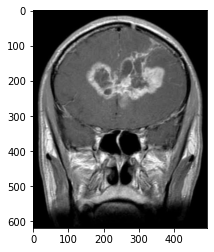

In [60]:
imagem = 'yes_tumor/image(1).jpg'
classificador_de_imagens(imagem)

Previsão:.... 0


'no_tumor'

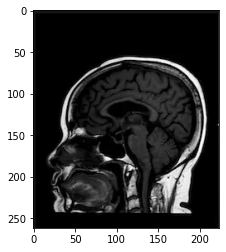

In [61]:
imagem = 'no_tumor/image(102).jpg'
classificador_de_imagens(imagem)